# Read Dataset

In [53]:
import numpy as np
import pandas as pd
import os

pd.options.mode.chained_assignment = None  # default='warn'

# read dataset
data = pd.read_parquet("../data/dataset/shs100k2/data.parquet")
data = data.explode("title").explode("performer")
#data["performer_single"] = data.performer.apply(lambda x: x[0] if len(x) > 0 else '')
#data["title_single"] = data.title.apply(lambda x: x[0] if len(x) > 0 else '').str.lower()
#cols = ['set_id', 'yt_id', 'title', 'title_single', 'performer', 'performer_single', 'viewcount', 'split', 'TEXT', 'IOB']
#data = data[cols]


# Load prepared Wikidata or process Dump

In [29]:
if not os.path.isfile("../data/intermediate/wikidata.parquet"):

    def preprocess_dump(data: pd.DataFrame) -> pd.DataFrame:
        # basic preprocessing
        def get_english_name_or_first(label_dict):
            en_name = label_dict.get("en")
            if en_name:
                name = en_name.get("value").lower()
            else:
                other_names = list(label_dict.values())
                if len(other_names) > 0:
                    name = list(label_dict.values())[0]["value"]
                else:
                    name = ""
            return name
        data["name"] = data.labels.apply(get_english_name_or_first)
        data["nsitelinks"] = data.sitelinks.apply(len)
        data = data[["id", "name", "nsitelinks"]]
        return data    

    # groups
    data_groups = pd.read_json("/data/groups.ndjson", lines=True)
    data_groups = preprocess_dump(data_groups)
    data_groups["type"] = "Group"

    # humans
    data_solo = pd.read_json("/data/soloartists.ndjson", lines=True)
    data_solo = preprocess_dump(data_solo)
    data_solo["type"] = "Human"

    # works
    data_works = pd.read_json("/data/works.ndjson", lines=True).dropna(subset="labels")
    data_works = preprocess_dump(data_works)
    data_works["type"] = "Work"

    data_wikidata = pd.concat([data_groups, data_solo, data_works], axis=0, ignore_index=True).drop_duplicates(subset="id")
    data_wikidata.to_parquet("../data/intermediate/wikidata.parquet")
else:

    data_wikidata = pd.read_parquet("../data/intermediate/wikidata.parquet")

if not "exposure" in data_wikidata.columns:
    def compute_exposure(data: pd.DataFrame) -> pd.DataFrame:
        # rank
        def get_rank(data: pd.DataFrame, column: str) -> pd.Series:
            data = data.sort_values(by=column, ascending=False)
            ranks = data[column].rank(method='min', ascending=False)
            return ranks
        data["rank"] = get_rank(data, "nsitelinks")

        #  exposure

        def exposure(rank, S):
            return np.log(S) - np.log(rank)
        data["exposure"] = data["rank"].apply(lambda x: exposure(x, len(data)))

        return data

    data_wikidata = compute_exposure(data_wikidata)


# Analysis

In [30]:
data_wikidata.type.value_counts()

type
Human    362406
Work     323348
Group    105704
Name: count, dtype: int64

In [31]:
data_wikidata.sort_values(by="nsitelinks", ascending=False).head(10)


,id,name,nsitelinks,type,rank,exposure
290297,Q1177254,david woodard,319,Human,1.0,13.581632
422959,Q2831,michael jackson,310,Human,2.0,12.888485
377075,Q762,leonardo da vinci,297,Human,3.0,12.483020
196207,Q5879,johann wolfgang von goethe,267,Human,4.0,12.195338
377073,Q255,ludwig van beethoven,259,Human,5.0,11.972194
331657,Q254,wolfgang amadeus mozart,259,Human,5.0,11.972194
286393,Q1339,johann sebastian bach,250,Human,7.0,11.635722
196199,Q882,charlie chaplin,247,Human,8.0,11.502191
331682,Q9358,friedrich nietzsche,242,Human,9.0,11.384408
105733,Q9554,martin luther,240,Human,10.0,11.279047


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


(0.0, 50.0)

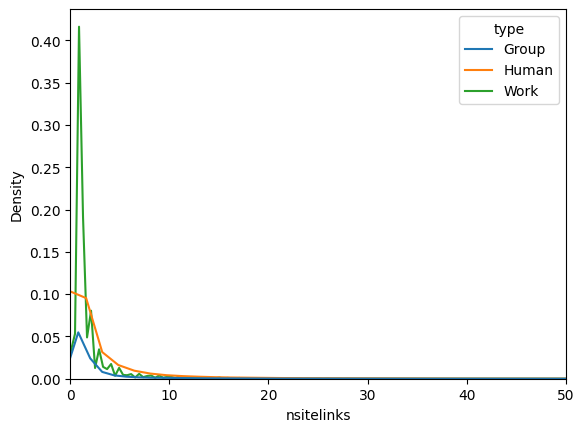

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data_wikidata, x="nsitelinks", hue="type")
plt.xlim(0,50)


# Merge 

In [88]:
data_artists = pd.merge(
        data, 
        data_wikidata.loc[data_wikidata.type.isin(["Group", "Human"])].add_suffix("_wd"), 
        left_on="performer", right_on="name_wd", how="left")

id_cols = ['set_id', 'ver_id', 'yt_id', 'title', 'performer', 'split', 'part', 'human_annotated']
agg_cols = ['id_wd', 'name_wd', 'nsitelinks_wd', 'type_wd', 'rank_wd', 'exposure_wd']


data_artists = data_artists[id_cols+agg_cols].groupby(id_cols, as_index=False).agg(
    {'id_wd': lambda x: list(x), 'type_wd': lambda x: list(x), 
     'nsitelinks_wd': ["min", "median", "max"], 
      'rank_wd': ["min", "median", "max"], 'exposure_wd': ["min", "median", "max"]})

n=5
print(f"{n} random non-matched artists:")
data_artists.loc[data_artists[('nsitelinks_wd', 'max')].isna()].sample(n).performer.to_list()


5 random non-matched artists:


['inger marie',
 'orch. della canzone',
 'horace silver trio',
 'tubes',
 'the magnificent men']

In [95]:
data_works = pd.merge(
    data,
    data_wikidata.loc[data_wikidata.type == "Work"].add_suffix("_wd"),
    left_on="title", right_on="name_wd", how="left")

id_cols = ['set_id', 'ver_id', 'yt_id', 'title', 'performer', 'split', 'part', 'human_annotated']
agg_cols = ['id_wd', 'nsitelinks_wd', 'type_wd', 'rank_wd', 'exposure_wd']

data_works = data_works[id_cols+agg_cols].groupby(id_cols, as_index=False).agg(
    {'id_wd': lambda x: list(x), 'type_wd': lambda x: list(x), 
     'nsitelinks_wd': ["min", "median", "max"], 
      'rank_wd': ["min", "median", "max"], 'exposure_wd': ["min", "median", "max"]})

n=5
print(f"{n} random non-matched artists:")
data_works.loc[data_works[("exposure_wd", "max")].isna()].sample(n).title.to_list()



5 random non-matched artists:


['How Deep Is the Ocean',
 'Yellow',
 "This Guy's in Love with You",
 'Chim Chim Cheree',
 'Baby Face']

In [103]:

__artists = data_artists[["performer", "nsitelinks_wd", "exposure_wd"]].dropna().drop_duplicates()
wd_cols = "name", "sitelinks_min", "sitelinks_median", "sitelinks_max", "exposure_min", "exposure_median", "exposure_max"
__artists.columns = wd_cols
__artists["Entity"] = "Artist"

__works = data_works[["title", "nsitelinks_wd", "exposure_wd"]].dropna().drop_duplicates()
__works.columns = wd_cols
__works["Entity"] = "WoA"

data_merged = pd.concat([__artists, __works])
data_merged

,name,sitelinks_min,sitelinks_median,sitelinks_max,exposure_min,exposure_median,exposure_max,Entity
0,helen jepson,3.0,3.0,3.0,1.805220,1.805220,1.805220,Artist
1,billie holiday,84.0,84.0,84.0,7.729430,7.729430,7.729430,Artist
6,the ravens,5.0,5.0,5.0,2.301332,2.301332,2.301332,Artist
7,ethel waters,32.0,32.0,32.0,5.243087,5.243087,5.243087,Artist
8,jane powell,33.0,33.0,33.0,5.305492,5.305492,5.305492,Artist
...,...,...,...,...,...,...,...,...
128631,All I Do,1.0,1.0,1.0,1.008419,1.008419,1.008419,WoA
128714,46,4.0,4.0,4.0,2.069807,2.069807,2.069807,WoA
128715,54,1.0,1.0,1.0,1.008419,1.008419,1.008419,WoA
128989,Atlantis,1.0,1.0,1.0,1.008419,1.008419,1.008419,WoA


/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/miniconda3/envs/torch21/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


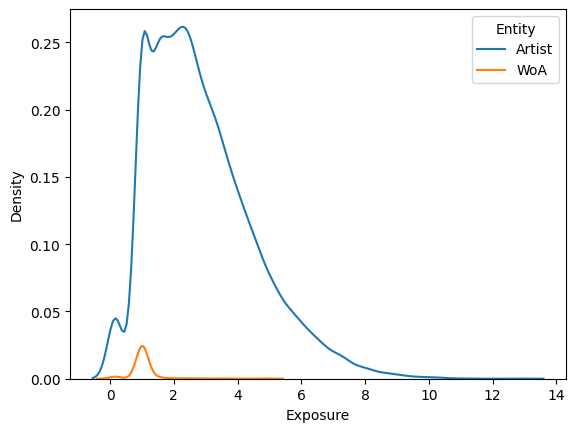

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data_merged, x="exposure_max", hue="Entity")
plt.xlabel("Exposure")
plt.savefig("../figures/kde_exposure.pdf")
plt.show()


In [127]:
plot_data[plot_data.variable == "Artist"].sort_values(by="value", ascending=False).drop_duplicates(
    subset="performer_single"
).head(30)[["performer_single", "value"]]


,performer_single,value
190308,michael jackson,12.888485
366361,the beatles,11.183737
288897,marilyn monroe,11.016683
235763,elvis presley,10.691260
296181,marlene dietrich,10.403578
353459,queen,10.362756
190896,lady gaga,10.323536
283404,the doors,10.285795
208064,madonna,10.214336
269144,bob dylan,10.180435


In [128]:
plot_data[plot_data.variable == "WoA"].sort_values(by="value", ascending=False).drop_duplicates(
    subset="title_single"
).head(30)[["title_single", "value"]]


,title_single,value
136600,sgt. pepper's lonely hearts club band,7.538999
4166,thriller,6.894523
116526,please please me,6.755087
72314,a hard day's night,6.602487
84461,help!,6.504978
3312,wish you were here,6.504978
5866,born this way,6.450733
97535,yellow submarine,6.450733
180139,master of puppets,6.342417
140775,femme fatale,6.254509


In [131]:
data.title.sample(10)


142628                [Big Spender]
142729                       [Sing]
169972                    [Believe]
149719                     [Dreams]
124188                      [Hello]
104667         [Moonlight Serenade]
44640                    [Stardust]
166419        [My Boyfriend's Back]
83823          [How Great Thou Art]
75131     [I Get a Kick out of You]
Name: title, dtype: object